# Data cleaning for income prediction 

In [1]:
#importing packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading in the data

In [2]:
#loading dataset 
df=pd.read_csv("/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/fake_transactional_data.csv")
#renaming the rows 
df=df.rename(columns={'from_totally_fake_account':'from_account', 'monopoly_money_amount':'money_amount', 'to_randomly_generated_account':'to_account', 'not_happened_yet_date':'date'})

All from_account values have a trailing '.0', let's remove this so it looks better:

In [3]:
set(df['from_account'].dropna().round() == df['from_account'].dropna())
df['from_account'] = df['from_account'].apply(lambda x: str(x).strip('.0') if str(x) != 'nan' else x)


### A few modifications

In [4]:
#converting date to date format
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

### Describing the data

In [5]:
#check dimensions of the data
print('\n shape:',df.shape)

print('\n head: \n', df.head())
print('\n info:')
df.info()

# Finding out the range of dates
print('\n Date range:', df["date"].min(), df["date"].max())


 shape: (12004116, 4)

 head: 
   from_account  money_amount           to_account       date
0          NaN          4.00               CINEMA 2025-01-01
1        40544          4.60  A_LOCAL_COFFEE_SHOP 2025-01-01
2        88339          2.40                40544 2025-01-01
3        85149          4.65  A_LOCAL_COFFEE_SHOP 2025-01-01
4        18555          2.40                85149 2025-01-01

 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12004116 entries, 0 to 12004115
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   from_account  object        
 1   money_amount  float64       
 2   to_account    object        
 3   date          datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 366.3+ MB

 Date range: 2025-01-01 00:00:00 2025-10-02 00:00:00


#### Map of missing Values

<AxesSubplot:>

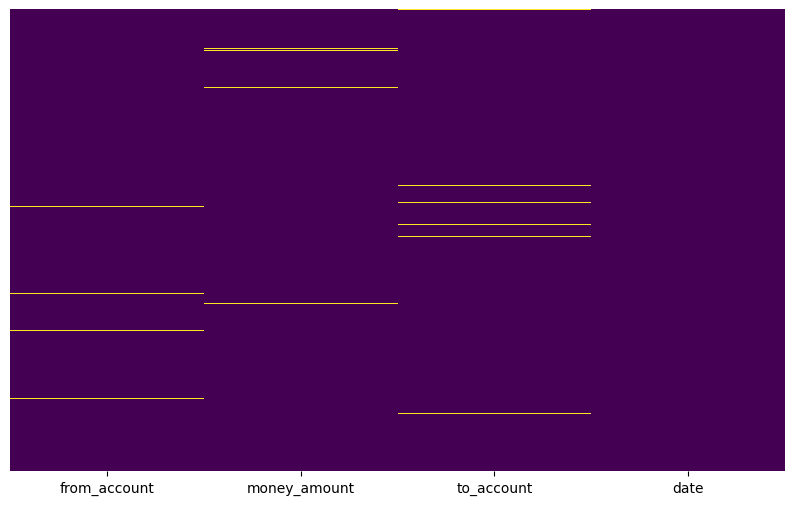

In [6]:
#Visualizing the missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cmap='viridis', cbar=False)

Here I am just checking for any obvious patterns in the NaN values, such as transactions where each feature is NaN

#### This function returns the NA status of each column

In [7]:
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
        if missing_vals == 0:
             print(f"{col} => No missing values")
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
    
    if total == 0:
        print("no missing values left")

In [8]:
print("\n How many missing values each columns has and what percentage this is:")    
#Using the function above to see our missing values  
missing_cols(df)       



 How many missing values each columns has and what percentage this is:
from_account => 139974
from_account => 1.17%
money_amount => 140256
money_amount => 1.17%
to_account => 140100
to_account => 1.17%
date => 1
date => 0.0%


While 1% does not seem like a lot, this is hundreds of thousands of rows, so we shall not by so quick to discard them. 
We seem to have one interesting case where there is one missing date. 

In [9]:
np.where(df['date'].isna())[0]

array([12004115])

In [10]:
df.loc[12004115]

from_account      100694
money_amount        2.25
to_account      GOURMET_
date                 NaT
Name: 12004115, dtype: object

### Splitting up the data into between account payments and to business payments

In [11]:
df1 = df.copy() #Making a copy of the df
df1['to_account'] = pd.to_numeric(df['to_account'], errors = 'coerce') # df1 is now df but where to account is non numeric NaN will show
df_between = df1[pd.notnull(df1['to_account'])] #Removing all the NaN rows, such that we are only left with accoun to account transaction
numeric_to_accounts = df_between['to_account'].astype(int).values #creating a list with all the to accounts as an integer
numeric_to_accounts = [str(x) for x in numeric_to_accounts] #Changing each element in numeric_to_accounts into a string
df_expenditure = df[~df['to_account'].isin(numeric_to_accounts)] #Creating df_expenditure by excluding all account to account transactions from our original df

In [12]:
#Printing descriptions of these 2 new df's
print('Between accounts head:', df_between.head())
print('\n Between accounts description', df_between.describe())


Between accounts head:    from_account  money_amount  to_account       date
2         88339          2.40     40544.0 2025-01-01
4         18555          2.40     85149.0 2025-01-01
6         80792          1.95     18555.0 2025-01-01
19        39262          4.50     30264.0 2025-01-01
51        53483          5.50     75744.0 2025-01-01

 Between accounts description        money_amount    to_account
count  2.950750e+06  2.985833e+06
mean   3.186091e+01  5.115173e+04
std    1.661347e+02  2.884507e+04
min    1.450000e+00  1.000000e+03
25%    5.000000e+00  2.583800e+04
50%    6.000000e+00  5.129000e+04
75%    6.500000e+00  7.588100e+04
max    1.995000e+03  1.009880e+05


In [13]:
df_expenditure['to_account'].unique()

array(['CINEMA', 'A_LOCAL_COFFEE_SHOP', 'HIPSTER_COFFEE_SHOP',
       'TOTALLY_A_REAL_COFFEE_SHOP', 'COFFEE_SHOP', 'CAFE', 'A_CAFE',
       'LOCAL_RESTAURANT', 'PUB', 'GOURMET_COFFEE_SHOP', nan,
       'SANDWICH_SHOP', 'LOCAL_WATERING_HOLE', 'TOY_SHOP',
       'PRETENTIOUS_COFFEE_SHOP', 'BAR', 'DVD_SHOP', 'COMIC_BOOK_SHOP',
       'LUNCH_VAN', 'DEPARTMENT_STORE', 'KEBAB_SHOP', 'LUNCH_PLACE',
       'NERDY_BOOK_STORE', 'WINE_BAR', 'SECOND_HAND_BOOKSHOP',
       'KIDS_CLOTHING_SHOP', 'RESTAURANT', 'LOCAL_PUB', 'CLOTHES_SHOP',
       'BOOKSHOP', 'LOCAL_BOOKSHOP', 'FASHION_SHOP',
       'FASHIONABLE_SPORTSWARE_SHOP', 'SCHOOL_SUPPLY_STORE',
       'TRAINER_SHOP', 'COCKTAIL_BAR', 'KIDS_ACTIVITY_CENTRE',
       'VIDEO_GAME_STORE', 'TECH_SHOP', 'TAKEAWAY_CURRY', 'WHISKEY_BAR',
       'CHILDRENDS_SHOP', 'PET_SHOP', 'DIY_STORE', 'GAME_SHOP',
       'INDIAN_RESTAURANT', 'TAKEAWAY', 'PET_TOY_SHOP', 'RUNNING_SHOP',
       'CHINESE_RESTAURANT', 'COOKSHOP', 'HOME_IMPROVEMENT_STORE',
       'CHINESE_T

In [14]:
print('\n Expenditure head:', df_expenditure.head())
print('\n Expenditure description', df_expenditure.describe())



 Expenditure head:   from_account  money_amount                  to_account       date
0          NaN          4.00                      CINEMA 2025-01-01
1        40544          4.60         A_LOCAL_COFFEE_SHOP 2025-01-01
3        85149          4.65         A_LOCAL_COFFEE_SHOP 2025-01-01
5        18555          4.10         HIPSTER_COFFEE_SHOP 2025-01-01
7        18555          4.45  TOTALLY_A_REAL_COFFEE_SHOP 2025-01-01

 Expenditure description        money_amount
count  8.913110e+06
mean   1.366975e+01
std    2.449926e+01
min    1.450000e+00
25%    2.450000e+00
50%    7.000000e+00
75%    1.350000e+01
max    1.990000e+03


### Filling in missing money amount

In [15]:
#This function takes in a df and outputs a list of all the means for each row by grouping by to and from account
def fill(df):
    s = df.groupby(['from_account', "to_account"])['money_amount'].mean()
    df2 = df[['from_account', 'to_account']].merge(s, on=['from_account', 'to_account'], how='left')
    df2 = df2.set_index(df.index)
    return(df2['money_amount'])

For account to account transactions, we look at each NaN money_amount and ask how much does this account normally send to this other account, by getting the mean of past transactions. If there are no past transactions we remove the row entirely

In [16]:
df_between['money_amount'].fillna(fill(df_between), inplace=True) #Using the function to replace all NaN's in the df_between df with the average of past transactions from one specific account to another specific account. 
df_between=df_between.dropna(axis=0, subset="money_amount") #All remaining NaN's are dropped
missing_cols(df_between)

/var/folders/py/d721tqvn39xbrq83g84j15pm0000gn/T/ipykernel_44252/904791043.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_between['money_amount'].fillna(fill(df_between), inplace=True) #Using the function to replace all NaN's in the df_between df with the average of past transactions from one specific account to another specific account.


from_account => 34429
from_account => 1.15%
money_amount => No missing values
to_account => No missing values
date => No missing values


For account to business transactions, we look at each NaN money_amount and ask how much does this account normally spend at this business, by getting the mean of past transactions. If there are no past transactions, then we ask how do other accounts normally spend here? Again by taking the mean. For any other remaining NaN's, we remove the row entirely.

In [17]:
df_expenditure['money_amount'].fillna(fill(df_expenditure), inplace=True) #Using the function to replace all NaN's in the df_expenditure df with the average of past transactions from one specific account to the specific business. 
s = df_expenditure.groupby('to_account')['money_amount'].mean() #Creating a df of the average spend at each business
df_expenditure['money_amount'].fillna(df_expenditure['to_account'].map(s), inplace=True) #Any remaining NaN's are filled in using s
df_expenditure=df_expenditure.dropna(axis=0, subset="money_amount") #All remaining NaN's are dropped
missing_cols(df_expenditure)


/var/folders/py/d721tqvn39xbrq83g84j15pm0000gn/T/ipykernel_44252/1801862313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expenditure['money_amount'].fillna(fill(df_expenditure), inplace=True) #Using the function to replace all NaN's in the df_expenditure df with the average of past transactions from one specific account to the specific business.
/var/folders/py/d721tqvn39xbrq83g84j15pm0000gn/T/ipykernel_44252/1801862313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expenditure['money_amount'].fillna(df_expenditure['to_account'].map(s), inplace=True) #Any remaining NaN's are filled in using s


from_account => 105136
from_account => 1.17%
money_amount => No missing values
to_account => 138497
to_account => 1.54%
date => 1
date => 0.0%


In [18]:
print('I have deleted', (df.shape[0] - (df_between.shape[0] + df_expenditure.shape[0])), 'rows')

I have deleted 2074 rows


### We can now bring the two df's back together

In [19]:
df = pd.concat([df_expenditure, df_between], sort=False).sort_index() #Concatinating the two df's and the sorting by index so that we preserve the original order
df.head()

,from_account,money_amount,to_account,date
0,NaN,4.00,CINEMA,2025-01-01
1,40544,4.60,A_LOCAL_COFFEE_SHOP,2025-01-01
2,88339,2.40,40544.0,2025-01-01
3,85149,4.65,A_LOCAL_COFFEE_SHOP,2025-01-01
4,18555,2.40,85149.0,2025-01-01


In [20]:
missing_cols(df)

from_account => 139565
from_account => 1.16%
money_amount => No missing values
to_account => 138497
to_account => 1.15%
date => 1
date => 0.0%


We have successfully now got a df with no missing money_amount

As this task is to predict income let's begin narrowing our focus on customers. To do this we build a new df for all of our customers

### New customer df 

In [21]:
#creating new dfs to summarise customers
df_customers = df.groupby('from_account').agg({'money_amount':['min','max','mean','sum','count'], 'to_account': pd.Series.mode})
print('head of customers df:\n',df_customers.head())
print('\n There are {} customers'.format(df_customers.shape[0]))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")
/Library/Frameworks/Python.framework/Ver

head of customers df:
              money_amount                                          \
                      min      max       mean           sum count   
from_account                                                        
1                    1.45  1960.00  14.853905  37565.525305  2529   
100002               1.45   299.00  14.959220  15527.670740  1038   
100019               1.45  1955.00  33.762143  22924.494825   679   
100027               1.45   381.25  22.950110  15927.376375   694   
10004                1.45   302.50  10.571419  13415.130350  1269   

                       to_account  
                             mode  
from_account                       
1             A_LOCAL_COFFEE_SHOP  
100002                        PUB  
100019        LOCAL_WATERING_HOLE  
100027                     6053.0  
10004                 COFFEE_SHOP  

 There are 12685 customers


I notice that some of the customer ID's look different, let's investigate this:

In [81]:
df_customers['customer_ID'] = df_customers.index
df_customers['length_ID'] = df_customers['customer_ID'].apply(lambda x: len(x))
df_customers.head(15)

money_amount                                          \
                      min      max       mean           sum count   
from_account                                                        
1                    1.45  1960.00  14.853905  37565.525305  2529   
100002               1.45   299.00  14.959220  15527.670740  1038   
100019               1.45  1955.00  33.762143  22924.494825   679   
100027               1.45   381.25  22.950110  15927.376375   694   
10004                1.45   302.50  10.571419  13415.130350  1269   
100053               1.45  1925.00  21.441289  22148.851270  1033   
100056               1.45   457.50  16.533270  13243.148920   801   
100064               1.45   330.00  15.584930  16909.648720  1085   
100065               1.95  1980.00  42.992085  22312.892078   519   
100083               1.45   198.00  13.426447  13614.417441  1014   
100086               1.45   581.67  16.918440  15954.088651   943   
100098               1.45  1910.00  21.828583  25015.555845  1146   
100105               1.45  1860.00  27.348284  26500.487237   969   
100115               1.45   268.75  13.594694  15321.220060  1127   
10012                1.45   430.00  15.921106  13755.835963   864   

                       to_account customer_ID length_ID  
                             mode                        
from_account                                             
1             A_LOCAL_COFFEE_SHOP           1         1  
100002                        PUB      100002         6  
100019        LOCAL_WATERING_HOLE      100019         6  
100027                     6053.0      100027         6  
10004                 COFFEE_SHOP       10004         5  
100053                        PUB      100053         6  
100056                        PUB      100056         6  
100064                        BAR      100064         6  
100065                        PUB      100065         6  
100083                        PUB      100083         6  
100086                    74488.0      100086         6  
100098        GOURMET_COFFEE_SHOP      100098         6  
100105                        PUB      100105         6  
100115                    40459.0      100115         6  
10012                         PUB       10012         5

In [80]:
sum = 0
count = 0
list = []
for i in df_customers['length_ID'].value_counts():
    list.append(df_customers['length_ID'].value_counts().index[count])
    sum += i
    print(round(sum/len(df_customers)*100,3),'% of the customers have account numbers of length', list)
    count+=1

81.892 % of the customers have account numbers of length [5]
97.217 % of the customers have account numbers of length [5, 4]
98.81 % of the customers have account numbers of length [5, 4, 3]
99.819 % of the customers have account numbers of length [5, 4, 3, 6]
99.992 % of the customers have account numbers of length [5, 4, 3, 6, 2]
100.0 % of the customers have account numbers of length [5, 4, 3, 6, 2, 1]


### Clustering 

In [86]:
print(df_customers.columns)
customers_pca  = df_customers.loc[:, ~df_customers.columns.isin([(  'to_account',  'mode'), ( 'customer_ID',      ''), (   'length_ID',      '')])]

MultiIndex([('money_amount',   'min'),
            ('money_amount',   'max'),
            ('money_amount',  'mean'),
            ('money_amount',   'sum'),
            ('money_amount', 'count'),
            (  'to_account',  'mode'),
            ( 'customer_ID',      ''),
            (   'length_ID',      '')],
           )


Explained variance ratio [0.99348497 0.00497666 0.00153821]


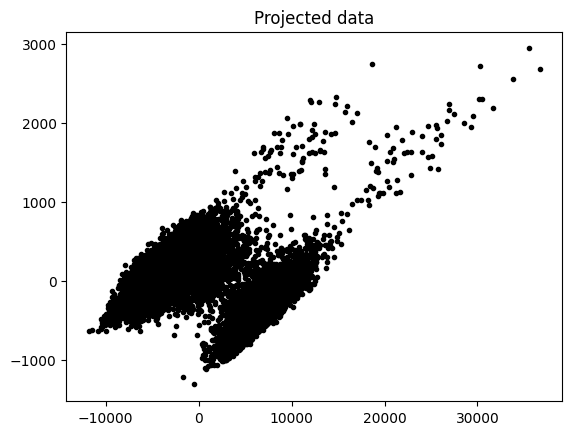

In [87]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(customers_pca)
# This should equal the sum of the first two values in the cumulative proportion plot
print('Explained variance ratio '+ str(pca.explained_variance_ratio_))

# Project data onto first two principal components
projX = pca.transform(customers_pca)
plt.figure(4)
plt.plot(projX[:,0], projX[:,1], 'k.')
plt.title('Projected data')
plt.show()

In [24]:
#creating new dfs to summarise customers


df_customers_between = df_between.groupby('from_account').agg({'money_amount':['min','max','mean','sum','count'], 'estimated_income':'min', 'to_account': pd.Series.mode})
print('\n head of customers between df:',df_customers.head())

df_customers_expenditure = df_expenditure.groupby('from_account').agg({'money_amount':['min','max','mean','sum','count'], 'estimated_income':'min', 'to_account': pd.Series.mode})
print('\n head of customers expenditure df:',df_customers.head())


KeyError: "Column(s) ['estimated_income', 'money_amount_x'] do not exist"

In [ ]:

#df.to_csv('12FebDSMP_df.csv')
#df_between.to_csv('16FebDSMP_df_between.csv')
#df_expenditure.to_csv('16FebDSMP_df_expenditure.csv')
#df_customers_between.to_csv('16FebDSMP_df_customers_between.csv')
#df_customers_expenditure.to_csv('16FebDSMP_df_customers_expenditure.csv')